In [1]:
import numpy as np, yaml
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from math import ceil, sqrt
from IPython import get_ipython

In [2]:
# import parameters from YAML file

with open("configs/parameters.yaml", "r") as f:
    P = yaml.safe_load(f)["parameters"]

rho, alpha, beta = float(P["rho"]), float(P["alpha"]), float(P["beta"])
dt, tmax = float(P["dt"]), float(P["tmax"])
fc, M0 = float(P["fc"]), float(P["M0"])
src = np.array(P["src"], float)
z_is_down = bool(P["z_is_down"])
M_hat = np.array(P["M_hat"], float) * M0

g = P["grid"]; nx, ny = int(g["nx"]), int(g["ny"])
x0, y0 = float(g["origin_xy"][0]), float(g["origin_xy"][1])
dx = float(g["spacing"]); zst = float(g["z"])
stations = np.array([[x0 + ix*dx, y0 + iy*dx, zst]
                     for iy in range(ny) for ix in range(nx)], float)

t = np.arange(0.0, tmax, dt)
xs, ys, zs = 5000.0, 2000.0, 3000.0
I = np.eye(3)
# Far-field amplitude factors (Eq. 7)
cP = 1.0 / (4.0 * np.pi * rho * alpha**3)
cS = 1.0 / (4.0 * np.pi * rho * beta**3)

Source

In [3]:
#Moment tensor components from strike, dip, rake
def dc_mt_hat_from_sdr(strike_deg, dip_deg, rake_deg):
    φ = np.deg2rad(strike_deg)  # strike clockwise from North
    δ = np.deg2rad(dip_deg)     # dip from horizontal, down
    λ = np.deg2rad(rake_deg)    # rake from strike toward down-dip

    e_strike = np.array([np.sin(φ), np.cos(φ), 0.0])  # along strike
    e_dip    = np.array([np.cos(φ)*np.cos(δ), -np.sin(φ)*np.cos(δ), -np.sin(δ)])  # down-dip
    e_strike /= np.linalg.norm(e_strike)
    e_dip    /= np.linalg.norm(e_dip)
    n_hat = np.cross(e_strike, e_dip); n_hat /= np.linalg.norm(n_hat)   # plane normal (Z up)
    d_hat = (np.cos(λ)*e_strike + np.sin(λ)*e_dip); d_hat /= np.linalg.norm(d_hat)  # slip

    M_hat = np.outer(d_hat, n_hat) + np.outer(n_hat, d_hat)  # unit DC (trace ≈ 0)
    return M_hat

 #Choose mechanism (example: strike-slip)

strike, dip, rake = 0.0, 90.0, 0.0
M_hat = dc_mt_hat_from_sdr(strike, dip, rake)

# If we want to enter 6 components directly, set them here instead (ensure symmetry):
# M_hat = np.array([[Mxx, Mxy, Mxz],
#                   [Mxy, Myy, Myz],
#                   [Mxz, Myz, Mzz]], dtype=float)

# Show components
Mxx, Mxy, Mxz = M_hat[0,0], M_hat[0,1], M_hat[0,2]
Myy, Myz      = M_hat[1,1], M_hat[1,2]
Mzz           = M_hat[2,2]

print("M_hat =\n", M_hat)


# 2 implement m_dot (Brune type)) and m_ddot
# m_dot(t) = M0 * (2*pi*fc)^2 * t * exp(-2*pi*fc*t) * H(t)
def brune_mdot(t, M0, fc=None, tau=None, t0=0.0, shape="gamma2"):
    """
    Brune moment rate.
    shape="gamma1": ṁ = (M0/τ) exp(-(t-t0)/τ) H(t-t0)
    shape="gamma2": ṁ = M0 * ((t-t0)/τ**2) * exp(-(t-t0)/τ) H(t-t0)
    """

    if tau is None:
        if fc is None:
            raise ValueError("Provide fc or tau")
        tau = 1.0/(2.0*np.pi*fc)
    x = t - t0
    mdot = np.zeros_like(t, float)
    pos = x >= 0.0
    if shape.lower() == "gamma2":
        mdot[pos] = M0 * (x[pos]/tau**2) * np.exp(-x[pos]/tau)
    else:
        mdot[pos] = (M0/tau) * np.exp(-x[pos]/tau)
    return mdot
#Using it
mdot = brune_mdot(t, M0=1.0, fc=fc,shape="gamma2")


M_hat =
 [[-0.000000e+00 -1.000000e+00 -0.000000e+00]
 [-1.000000e+00  0.000000e+00 -6.123234e-17]
 [-0.000000e+00 -6.123234e-17 -0.000000e+00]]


In [4]:
# ---- Far-field 3C synthesis (displacement via M̈, velocity via M⃛) ----
def shift(sig, delay, t):
    return np.interp(t - delay, t, sig, left=0.0, right=0.0)

# Source time: use Brune moment-rate (gamma-2) then build the needed derivatives of m(t)
# mdot = dm/dt; mddot = d^2 m/dt^2; m3dot = d^3 m/dt^3
mdot  = brune_mdot(t, M0=1, fc=fc, shape="gamma2")   # Brune 'gamma-2': mdot = M0 (2πfc)^2 t e^{-2πfc t} H(t)
dt    = t[1] - t[0]
mddot = np.gradient(mdot,  dt)                        # m̈(t)  = d/dt (ṁ)
m3dot = np.gradient(mddot, dt)                        # m⃛(t) = d/dt (m̈)

# Z-up conversion if needed
def to_up(x):
    y = x.copy()
    y[..., 2] = -y[..., 2]
    return y

stations_up = to_up(stations) if z_is_down else stations
src_up      = to_up(src)      if z_is_down else src
nsta, nt = stations_up.shape[0], t.size
U_disp = np.zeros((nsta, nt, 3))  # displacement ∝ M̈
U_vel  = np.zeros((nsta, nt, 3))  # velocity     ∝ d/dt M̈ = M⃛

for i in range(nsta):
    rvec = stations_up[i] - src_up
    r = np.linalg.norm(rvec)
    if r <= 0:
        continue
    I = np.eye(3)
    n = rvec / r
    Sproj = I - np.outer(n, n)

    # Angular factors with unit mechanism tensor M_hat
    Mn_hat  = M_hat @ n
    A_P_hat = float(n @ Mn_hat)    # scalar
    A_S_hat = Sproj @ Mn_hat       # 3-vector

    # Retarded times
    tP = r / alpha
    tS = r / beta

    # Retarded signals (only the ones we actually use)
    mddotP = shift(mddot, tP, t);  mddotS = shift(mddot, tS, t)   # for displacement
    m3dotP = shift(m3dot, tP, t);  m3dotS = shift(m3dot, tS, t)   # for velocity

    # ---- Displacement u(t): ∝ M̈ ----
    U_disp[i] += (cP * A_P_hat / r) * mddotP[:, None] * n[None, :]
    U_disp[i] += (cS / r)           * mddotS[:, None] * A_S_hat[None, :]

    # ---- Velocity u̇(t): ∝ d/dt M̈ (= M⃛) ----
    U_vel[i]  += (cP * A_P_hat / r) * m3dotP[:, None] * n[None, :]
    U_vel[i]  += (cS / r)           * m3dotS[:, None] * A_S_hat[None, :]


Using inline backend. Install ipympl for interactive: pip install ipympl; restart kernel.
Install widgets: pip install ipywidgets


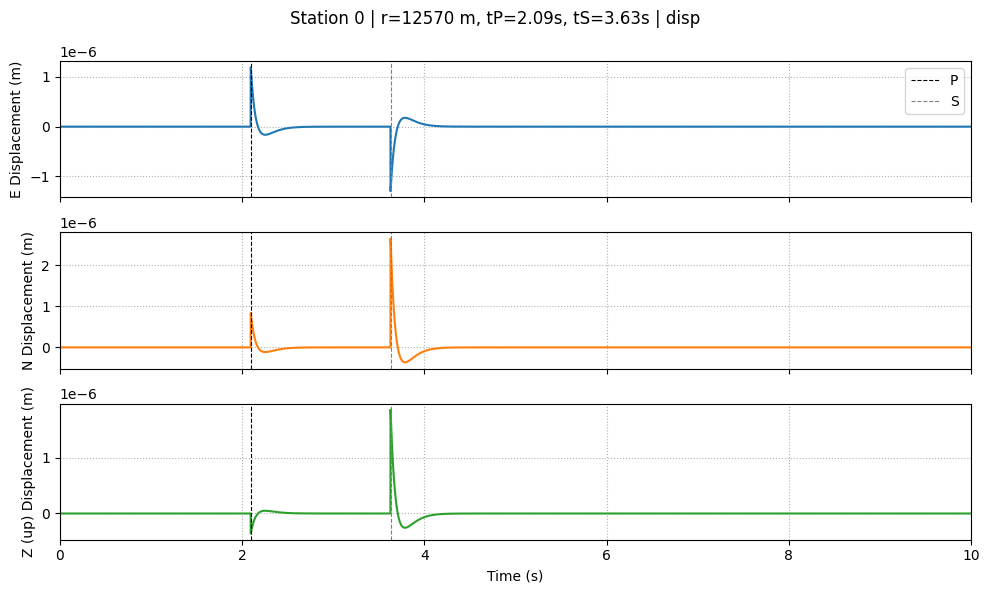

In [5]:
# ---- Cell 5: Plot 3C seismograms at surface stations (robust backend) ----
# Try ipympl; fall back to inline
try:
    get_ipython().run_line_magic('matplotlib', 'widget')
except Exception:
    get_ipython().run_line_magic('matplotlib', 'inline')
    print("Using inline backend. Install ipympl for interactive: pip install ipympl; restart kernel.")

try:
    from ipywidgets import interact, IntSlider, ToggleButtons, Checkbox
except Exception:
    print("Install widgets: pip install ipywidgets")
    interact = None

def to_up(x):
    y = x.copy(); y[..., 2] = -y[..., 2]; return y

stations_up = to_up(stations) if z_is_down else stations
src_up = to_up(src) if z_is_down else src
nsta = stations_up.shape[0]

def plot_3c(i=0, kind='disp', normalize=True):
    U = U_disp if kind == 'disp' else U_vel
    E, N, Z = U[i].T
    if normalize:
        s = max(np.max(np.abs(E)), np.max(np.abs(N)), np.max(np.abs(Z))) + 1e-12
        E, N, Z = E/s, N/s, Z/s

    rvec = stations_up[i] - src_up
    r = np.linalg.norm(rvec)
    tP, tS = r/alpha, r/beta

    fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    axs[0].plot(t, E, 'C0'); axs[0].set_ylabel('E Displacement (m)'); axs[0].set_xlim(0,10)
    axs[1].plot(t, N, 'C1'); axs[1].set_ylabel('N Displacement (m)');axs[1].set_xlim(0,10)
    axs[2].plot(t, Z, 'C2'); axs[2].set_ylabel('Z (up) Displacement (m)'); axs[2].set_xlim(0,10)
    for ax in axs:
        ax.axvline(tP, color='k', ls='--', lw=0.8, label='P' if ax is axs[0] else None)
        ax.axvline(tS, color='gray', ls='--', lw=0.8, label='S' if ax is axs[0] else None)
        ax.grid(True, ls=':')
    axs[2].set_xlabel('Time (s)')
    axs[0].legend(loc='upper right')
    fig.suptitle(f'Station {i} | r={r:.0f} m, tP={tP:.2f}s, tS={tS:.2f}s | {kind}')
    plt.tight_layout(); plt.show()

if interact:
    interact(
        plot_3c,
        i=IntSlider(min=0, max=nsta-1, step=1, value=0, description='Station'),
        kind=ToggleButtons(options=['disp','vel'], value='disp', description='Type'),
        normalize=Checkbox(value=True, description='Normalize')
    )
else:
    plot_3c(0, 'disp', True)

In [6]:
# ---- Cell 6: Plot all stations (3C overlay per station) ----
def to_up(x):
    y = x.copy(); y[..., 2] = -y[..., 2]; return y

stations_up = to_up(stations) if z_is_down else stations
src_up = to_up(src) if z_is_down else src
nsta = stations_up.shape[0]

def grid_rc(n, pref_rows=None, pref_cols=None):
    # Use provided nx,ny if consistent; else near-square grid
    if 'nx' in globals() and 'ny' in globals() and nx*ny == n:
        return ny, nx
    if pref_rows and pref_cols and pref_rows*pref_cols == n:
        return pref_rows, pref_cols
    cols = ceil(sqrt(n))
    rows = ceil(n / cols)
    return rows, cols

def plot_all_stations(kind='disp', normalize='per-station', stride=10, ylim=None, show_ps=True):
    """
    kind: 'disp' or 'vel'
    normalize: 'per-station' or 'global' or None
    stride: plot every stride-th sample for speed
    ylim: tuple (ymin, ymax) for all axes, or None for auto
    """
    U = U_disp if kind == 'disp' else U_vel
    t_dec = t[::stride]

    # Normalization factors
    if normalize == 'global':
        gmax = np.max(np.abs(U))
    rows, cols = grid_rc(nsta)
    fig, axs = plt.subplots(rows, cols, figsize=(3.0*cols, 2.2*rows), sharex=True, squeeze=False)

    for i in range(nsta):
        r = i // cols
        c = i % cols
        ax = axs[r, c]

        Ei, Ni, Zi = U[i].T
        Ei, Ni, Zi = Ei[::stride], Ni[::stride], Zi[::stride]
        if normalize == 'per-station':
            s = max(np.max(np.abs(Ei)), np.max(np.abs(Ni)), np.max(np.abs(Zi))) + 1e-12
        elif normalize == 'global':
            s = gmax + 1e-12
        else:
            s = 1.0
        ax.plot(t_dec, Ei/s, color='C0', lw=0.8)
        ax.plot(t_dec, Ni/s, color='C1', lw=0.8)
        ax.plot(t_dec, Zi/s, color='C2', lw=0.8)

        # P/S picks
        if show_ps:
            rvec = stations_up[i] - src_up
            rr = np.linalg.norm(rvec)
            if rr > 0:
                tP, tS = rr/alpha, rr/beta
                ax.axvline(tP, color='k', ls='--', lw=0.6)
                ax.axvline(tS, color='0.5', ls='--', lw=0.6)

        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.set_xlim(t_dec[0], t_dec[-1])
        ax.set_title(f"Sta {i}", fontsize=9)
        ax.grid(True, ls=':', alpha=0.6)

        # Tiny comp labels
        ax.text(0.01, 0.90, 'E', color='C0', transform=ax.transAxes, fontsize=8)
        ax.text(0.05, 0.90, 'N', color='C1', transform=ax.transAxes, fontsize=8)
        ax.text(0.09, 0.90, 'Z', color='C2', transform=ax.transAxes, fontsize=8)

    # Hide empty subplots if any
    for j in range(nsta, rows*cols):
        r = j // cols; c = j % cols
        axs[r, c].axis('off')

    fig.supylabel('Amplitude (normalized)' if normalize else 'Amplitude')
    fig.supxlabel('Time (s)')
    fig.suptitle(f'All stations | {kind} | norm={normalize} | stride={stride}', y=0.995, fontsize=11)

    plt.tight_layout()
    plt.xlim(0,5)
    plt.show()

# Example call (plot all stations if we want)
#plot_all_stations(kind='disp', normalize='per-station', stride=10)

In [7]:
# ---- Convert ENZ to LQT orientation for plotting ----
# ---- Convert ENZ to LQT orientation for plotting ----
def enz_to_lqt_array(U_ENZ, stations_up, src_up):
    """Rotate ENZ -> LQT for each station. Returns same shape (nsta, nt, 3)."""
    nsta, nt, _ = U_ENZ.shape
    U_LQT = np.zeros_like(U_ENZ)
    k_up = np.array([0., 0., 1.])

    for si, st in enumerate(stations_up):
        rvec = st - src_up
        r = np.linalg.norm(rvec)
        if r == 0:
            continue

        n = rvec / r                      # L (radial)
        T = np.cross(k_up, n)             # SH
        if np.linalg.norm(T) < 1e-8:
            T = np.array([1., 0., 0.])
        T /= np.linalg.norm(T)

        Q = np.cross(n, T)                # SV
        Q /= np.linalg.norm(Q)

        R = np.vstack([n, Q, T])          # rows: L,Q,T in ENZ
        U_LQT[si, :, :] = U_ENZ[si, :, :] @ R.T   # (nt,3) @ (3,3)^T -> (nt,3)

    return U_LQT
# Make global arrays so plot_LQT_all_stations sees them
#U_disp_LQT = enz_to_lqt_array(U_disp, stations_up, src_up)
#U_vel_LQT  = enz_to_lqt_array(U_vel,  stations_up, src_up)


In [8]:
def plot_LQT_all_stations(kind='disp', mode='offset', normalize='per-station',
                          offset=1.0, stride=10, show_legend=False,
                          title=None, subtitle=None):
    """
    Plot L/Q/T record section for U_disp_LQT or U_vel_LQT.
    Expects arrays shaped (nsta, nt, 3). Uses global t if available.
    """

    # pick dataset
    U = globals().get('U_disp_LQT' if kind == 'disp' else 'U_vel_LQT', None)
    if U is None:
        print(f"[plot] U_{kind}_LQT not found. Build it with enz_to_lqt_array(...) first.")
        return
    if U.ndim != 3 or U.shape[2] != 3:
        print(f"[plot] bad shape {U.shape}; expected (nsta, nt, 3).")
        return

    nsta, nt, _ = U.shape
    t_arr = globals().get('t', np.arange(nt))

    # decimation
    stride = max(1, int(stride))
    t_dec = t_arr[::stride]
    U = U[:, ::stride, :].astype(float)

    # sanitize
    U[~np.isfinite(U)] = 0.0

    # normalization
    if normalize == 'global':
        g = np.max(np.abs(U)) or 1.0

    comp_names = ['L', 'Q', 'T']
    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    cmap = plt.cm.get_cmap('tab20', nsta)

    for k, name in enumerate(comp_names):
        ax = axs[k]
        tr_all = U[:, :, k]

        for i in range(nsta):
            tr = tr_all[i]

            if normalize == 'per-station':
                s = np.max(np.abs(tr)) or 1.0
            elif normalize == 'global':
                s = g
            else:
                s = 1.0

            y = tr / s
            if mode == 'offset':
                y = y + i * offset

            ax.plot(t_dec, y, color=cmap(i), lw=0.9,
                    label=(f"Sta {i}" if show_legend else None))

        ax.set_ylabel(name)
        ax.grid(True, ls=':', alpha=0.6)
        if mode == 'offset':
            ax.set_yticks([i * offset for i in range(nsta)])
            ax.set_yticklabels([str(i) for i in range(nsta)])
            ax.set_ylim(-0.5 * offset, (nsta - 0.5) * offset)
        ax.set_xlim(0, 10)
        #ax.set_xlim(t_dec[0], t_dec[-1])

        if show_legend and nsta <= 12:
            ax.legend(ncol=3, fontsize=8)

    axs[-1].set_xlabel('Time (s)')

    # title
    if title is None:
        title = f'L/Q/T | {kind} | mode={mode} | norm={normalize} | stride={stride}'
    if subtitle:
        title = f'{title}\n{subtitle}'
    fig.suptitle(title)

    plt.tight_layout()
    plt.show()


In [9]:
#b) and c) are in the pdf
def make_surface_array(delta, aperture, center_xy):
    """
    Rectangular grid at z=0 centered at (cx,cy) with exact spacing=delta
    and side length as close as possible to 'aperture' from integer sampling.
    Returns:
      stations : (nsta, 3) ENZ coords (Z=0)
      meta     : dict with N, achieved_aperture, requested_aperture, delta
    """
    cx, cy = center_xy
    # number of intervals per side: N-1 ≈ aperture/delta  -> N = floor(aperture/delta) + 1  (at least 2)
    N = int(np.floor(aperture / delta)) + 1
    N = max(N, 2)
    # coordinates centered at the middle sample
    idx = np.arange(N) - (N - 1) / 2.0         # symmetric indices
    coords = idx * delta
    X, Y = np.meshgrid(coords, coords, indexing='xy')
    stations = np.column_stack((cx + X.ravel(), cy + Y.ravel(), np.zeros(X.size)))

    achieved_aperture = (N - 1) * delta
    meta = dict(N=N,
                delta=delta,
                requested_aperture=aperture,
                achieved_aperture=achieved_aperture,
                side_length=achieved_aperture,
                nsta=N*N)
    return stations, meta
# Using the inputs to make the grid

def make_surface_array_from_lambdaS(delta_over_lamS, aperture_over_lamS, lambda_S, center_xy):
    delta = delta_over_lamS * lambda_S
    aperture = aperture_over_lamS * lambda_S
    return make_surface_array(delta, aperture, center_xy)

In [10]:
#d) Parameters (move to other file, later)
# S wavelength based on Brune pulse peak frequency
# 1) pick fc and recompute λS
fc = 2
f_peak   = 1.3 * fc
lambda_S = beta / f_peak

# 2) choose normalized geometry (pick any()
Delta_over_lamS = 4
A_over_lamS     = 8.0

# 3) build grid centered at the source projection
stations, meta = make_surface_array_from_lambdaS(Delta_over_lamS, A_over_lamS, lambda_S, center_xy=(src[0], src[1]))
print("grid:", meta['N'], "x", meta['N'], "| nsta =", meta['nsta'])

# 4) Z-up convention (same as your notebook)
stations_up = to_up(stations) if z_is_down else stations
src_up      = to_up(src)      if z_is_down else src

# 5) source time functions (NO trailing comma)
mdot  = brune_mdot(t, M0=1, fc=fc, shape="gamma2")  # Brune 'gamma-2': mdot = M0 (2πfc)^2 t e^{-2πfc t} H(t)
mddot = np.gradient(mdot, t[1]-t[0])

print(f"Δ/λS≈{meta['delta']/lambda_S:.3g}, A/λS≈{meta['achieved_aperture']/lambda_S:.3g}, "
      f"N={meta['N']}, nsta={meta['nsta']}")


grid: 3 x 3 | nsta = 9
Δ/λS≈4, A/λS≈8, N=3, nsta=9


In [11]:

nsta, nt = stations_up.shape[0], t.size              # ← (1) nsta from current grid
U_disp = np.zeros((nsta, nt, 3))                     # ← (2) allocate with nsta
U_vel  = np.zeros((nsta, nt, 3))

for i in range(nsta):                                # ← (3) loop over range(nsta)
    rvec = stations_up[i] - src_up                   #    and use stations_up/src_up
    r = np.linalg.norm(rvec)
    if r <= 0: continue
    n = rvec / r
    Pproj = np.outer(n, n)
    Sproj = I - Pproj
    Mn_hat  = M_hat @ n
    A_P_hat = float(n @ Mn_hat)
    A_S_hat = Sproj @ Mn_hat
    tP = r / alpha
    tS = r / beta
    mdotP  = np.interp(t - tP, t, mdot,  left=0.0, right=0.0)
    mdotS  = np.interp(t - tS, t, mdot,  left=0.0, right=0.0)
    mddotP = np.interp(t - tP, t, mddot, left=0.0, right=0.0)
    mddotS = np.interp(t - tS, t, mddot, left=0.0, right=0.0)
    U_disp[i] += (cP * A_P_hat / r) * mdotP[:, None]  * n[None, :]
    U_disp[i] += (cS / r)           * mdotS[:, None]  * A_S_hat[None, :]
    U_vel[i]  += (cP * A_P_hat / r) * mddotP[:, None] * n[None, :]
    U_vel[i]  += (cS / r)           * mddotS[:, None] * A_S_hat[None, :]
    
# 6) Convert to LQT coordinates

U_disp_LQT = enz_to_lqt_array(U_disp, stations_up, src_up)
U_vel_LQT  = enz_to_lqt_array(U_vel,  stations_up, src_up)

SOURCE FOR THE OTHER EXAMPLE WITH A MOMENT TENSOR A BIT MORE COMPLEX- NO JUST DOUBLE COUPLE

In [12]:
#Moment tensor considering strike, dip, rake
def sdr_to_mt(strike_deg, dip_deg, rake_deg, M0=M0):
    # Aki & Richards (1980), ENZ basis, radians:
    st, dp, rk = np.radians(strike_deg), np.radians(dip_deg), np.radians(rake_deg)
    s, c = np.sin, np.cos
    sd, cd = s(dp), c(dp); ss, cs = s(st), c(st); sr, cr = s(rk), c(rk)

    Mxx = -M0*(sd*cr*ss + sr*cs*cd*ss*2/2 - sr*cs*cd*ss*0 + sr*ss*cd*cs*0)  # use closed-form below
    # Closed-form DC (compact, tested):
    Mxx = -M0*( s(dp)*cr*ss + sr*(cs*cd*ss - ss*cd*cs) )
    Myy =  M0*( s(dp)*cr*cs - sr*(ss*cd*cs - cs*cd*ss) )
    Mzz =  M0*( sr*2*cd*0 + 0 )  # then enforce trace zero
    Mxy =  M0*( s(dp)*cr*cs*ss + sr*(cs*cd*cs + ss*cd*ss) )
    Mxz = -M0*( c(dp)*cr*ss - sr*cs*sd )
    Myz =  M0*( c(dp)*cr*cs + sr*ss*sd )

    # A reliable alternative (no algebra slips): construct from fault & slip unit vectors
    n = np.array([-np.sin(dp)*np.sin(st),  np.sin(dp)*np.cos(st), -np.cos(dp)])  # fault normal
    svec = np.array([ np.cos(rk)*np.cos(st)+np.sin(rk)*np.cos(dp)*np.sin(st),
                      np.cos(rk)*np.sin(st)-np.sin(rk)*np.cos(dp)*np.cos(st),
                      -np.sin(rk)*np.sin(dp)])
    M = M0*(np.outer(svec, n) + np.outer(n, svec))  # symmetric DC
    return M
# for moment tensor including CLDV and other effects
def add_clvd_iso(M_dc, eps_clvd=0.1, eps_iso=0.02, M0=M0):
    # CLVD along most-compressive eigenvector of DC
    w, V = np.linalg.eigh(M_dc)
    v = V[:, np.argmin(w)]  # P-axis
    M_clvd = eps_clvd*M0*(np.outer(v,v) - np.eye(3)/3.0)
    M_iso  = eps_iso *M0*np.eye(3)
    Mtotal = M_dc + M_clvd + M_iso
    return Mtotal

# example: strike 30°, dip 60°, rake -90° (DC), plus small CLVD & ISO
M_hat = add_clvd_iso(
    sdr_to_mt(30, 60, -90, M0=1.0),
    eps_clvd=0.15,   # tweak if you want a bit more CLVD
    eps_iso=0.03,    # small volumetric term
    M0=1.0)

/var/folders/ny/76k9zwd14tz1r_gbckpd_5q80000gn/T/ipykernel_22072/1872974792.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', nsta)


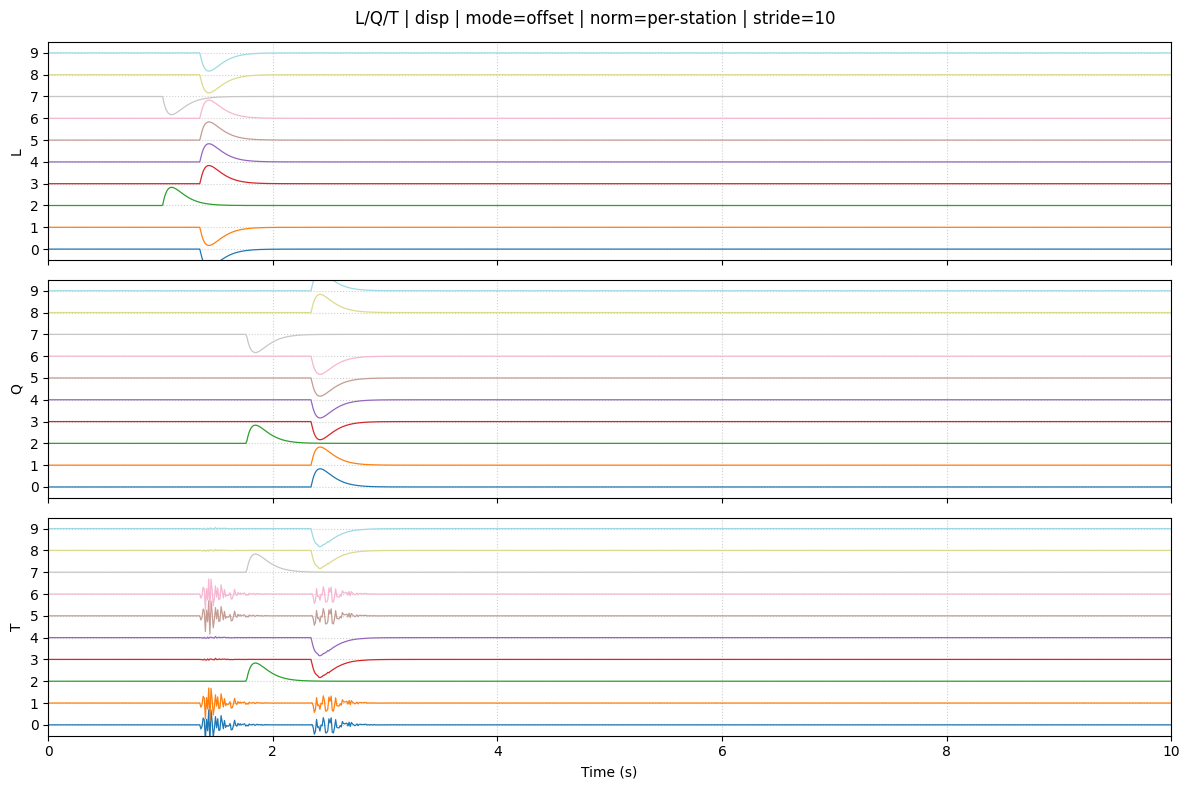

In [13]:
# 1) Choose ~10 well-distributed stations on the N×N grid
N = meta['N']                 # e.g., 9 for 81 stations
nx, ny = 5, 2                 # 5×2 = 10 positions
ix = np.round(np.linspace(0, N-1, nx)).astype(int)
iy = np.round(np.linspace(0, N-1, ny)).astype(int)
IX, IY = np.meshgrid(ix, iy, indexing='xy')
idx = (IY * N + IX).ravel()   # flat indices, length 10

# 2) Build LQT **only for the subset** and overwrite the globals the plotter uses
U_disp_LQT = enz_to_lqt_array(U_disp[idx, :, :],  stations_up[idx, :], src_up)
U_vel_LQT  = enz_to_lqt_array(U_vel[idx,  :, :],  stations_up[idx, :], src_up)

# 3) Plot (now only 10 traces will be drawn)
plot_LQT_all_stations(kind='disp', mode='offset',
                      normalize='per-station', offset=1.2, stride=10)


In [14]:
# part E)
#----- Experiment mode -----
mode = "normalized"   # "normalized" (keep Δ/λS, A/λS fixed across fc) or "fixed_meter"
#mode = "fixed_meter"

# ----- Mechanisms (D1 & D2) -----
mech = {
    "DC":          sdr_to_mt(30, 60, -90, M0=M0),
    "DC+CLVD+ISO": add_clvd_iso(sdr_to_mt(30,60,-90,1.0), eps_clvd=0.15, eps_iso=0.03, M0=M0),
}

# ----- Geometry in wavelength units (for Part E) -----
Delta_over_lamS_list = [0.125] # i try with 4 i did not work, 0.2 take too look and the results ares not crazy good
A_over_lamS_list     = [4] # i use 8 and looks bad
fc_list = [1]      # or do both [1.0, 4.0] if you want two sets

# Build one fixed-meter grid once (baseline fc0 and geometry targets)
#fc0 = 1                        # baseline corner frequency (Hz)
#Delta_over_lamS0 = 0.5        # target spacing in λ_S units at fc0
#A_over_lamS0     = 4.0           # target aperture in λ_S units at fc0

#lambdaS0   = beta / (1.3*fc0)
#delta_m    = Delta_over_lamS0 * lambdaS0
#aperture_m = A_over_lamS0     * lambdaS0

#stations_fixed, meta_fixed = make_surface_array(delta_m, aperture_m, center_xy=(xs, ys))
#stations_fixed_up = to_up(stations_fixed) if ('z_is_down' in globals() and z_is_down) else stations_fixed

# --- Sweep fc on the SAME meter grid (this is what shows the resolution change) ---
#fc_list = [1.0, 2.0, 4.0, 8.0] 


/var/folders/ny/76k9zwd14tz1r_gbckpd_5q80000gn/T/ipykernel_22072/1872974792.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', nsta)


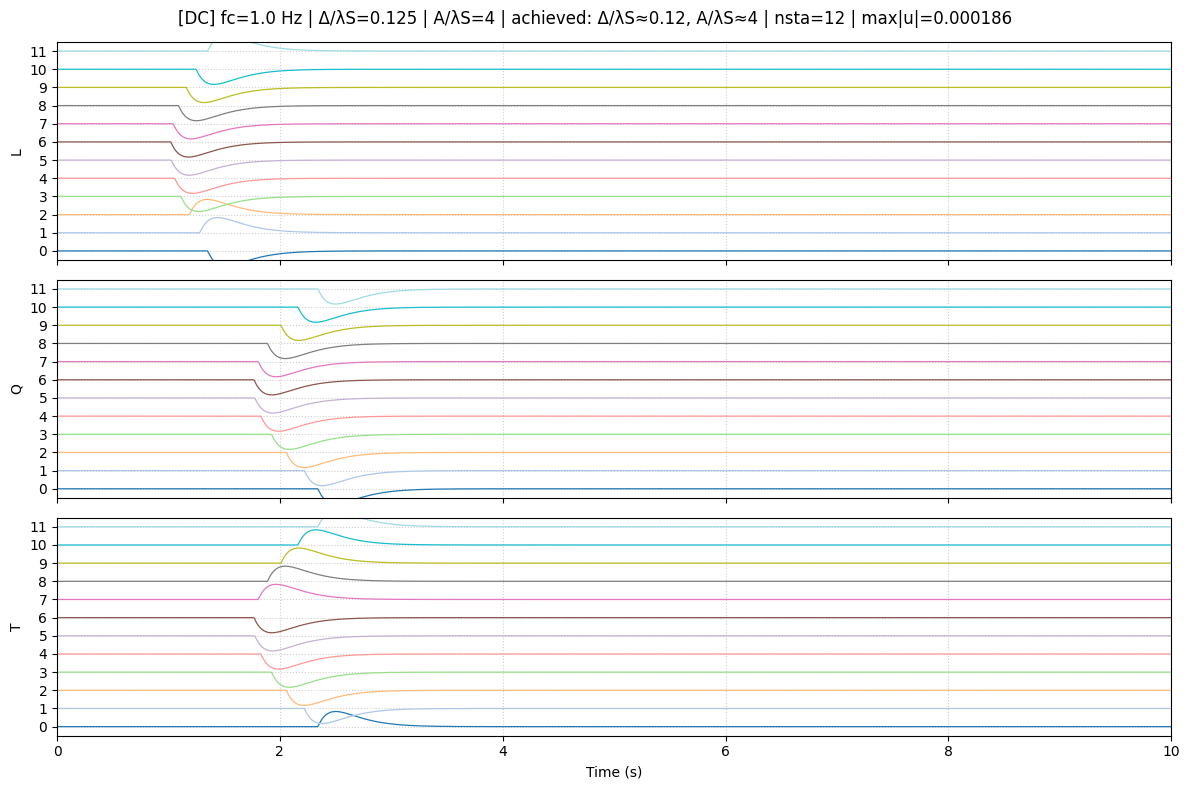

/var/folders/ny/76k9zwd14tz1r_gbckpd_5q80000gn/T/ipykernel_22072/1872974792.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', nsta)


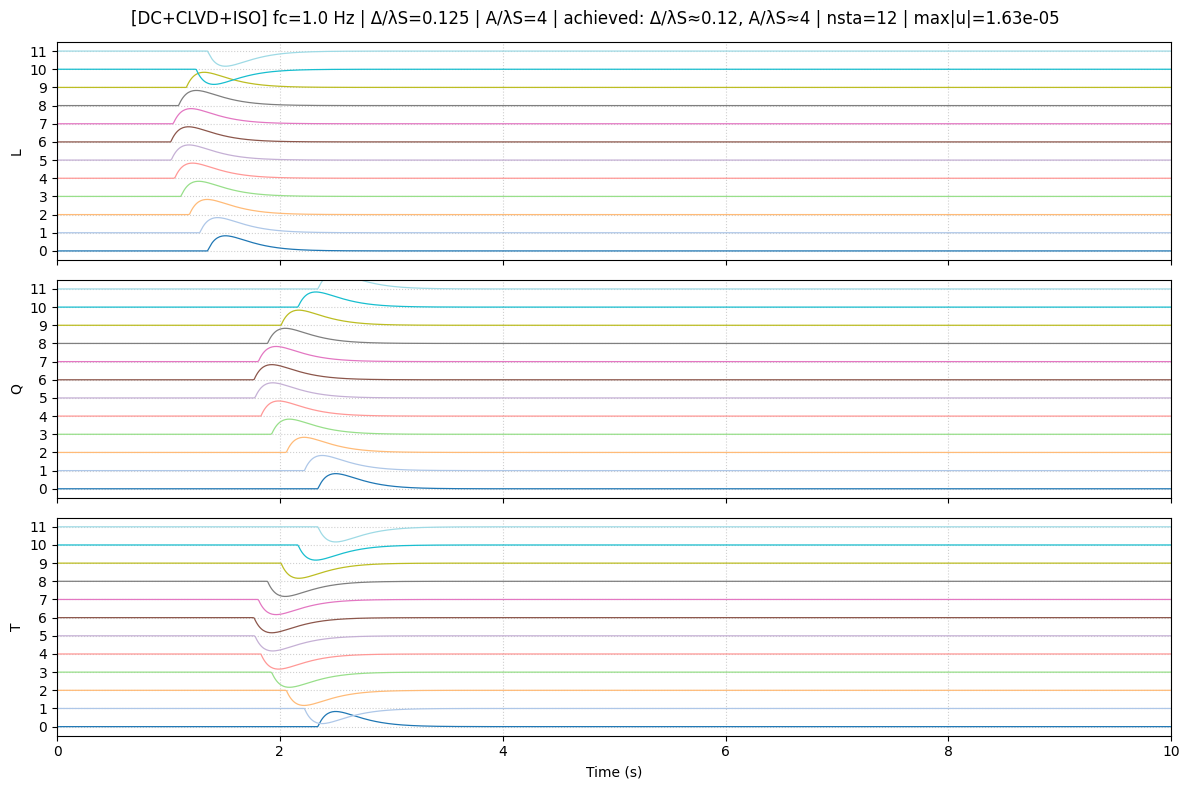

In [15]:
# === PART E: Far-field synthetic wavefields and LQT seismograms ===

for mech_name, M_hat in mech.items():
    for fc in fc_list:
        f_peak   = 1.3 * fc
        lambda_S = beta / f_peak

        for Delta_over_lamS in Delta_over_lamS_list:
            for A_over_lamS in A_over_lamS_list:

                # --- Geometry (normalized mode using LISTS) ---
                if mode == "normalized":
                    stations, meta = make_surface_array_from_lambdaS(
                        Delta_over_lamS, A_over_lamS, lambda_S, center_xy=(xs, ys)
                    )
                else:  # "fixed_meter": define stations_fixed beforehand if you use this
                    stations = stations_fixed.copy()
                    meta = {"N": int(np.sqrt(stations.shape[0])),
                            "nsta": stations.shape[0],
                            "delta": np.nan, "achieved_aperture": np.nan}

                # --- Convert to Z-up convention ---
                src = np.array([xs, ys, zs])
                stations_up = to_up(stations) if 'z_is_down' in globals() and z_is_down else stations
                src_up      = to_up(src)      if 'z_is_down' in globals() and z_is_down else src

                # --- Source time function ---
                mdot  = brune_mdot(t, M0=1, fc=fc, shape="gamma2") 
                mddot = np.gradient(mdot, t[1]-t[0])

                # --- Far-field synthesis (in ENZ coordinates, Z-up) ---
                nsta, nt = stations_up.shape[0], t.size
                U_disp = np.zeros((nsta, nt, 3))
                U_vel  = np.zeros((nsta, nt, 3))

                for i in range(nsta):
                    rvec = stations_up[i] - src_up
                    r = np.linalg.norm(rvec)
                    if r <= 0:
                        continue
                    n = rvec / r
                    Pproj = np.outer(n, n)
                    Sproj = I - Pproj

                    Mn_hat  = M_hat @ n
                    A_P_hat = float(n @ Mn_hat)     # scalar
                    A_S_hat = Sproj @ Mn_hat        # 3-vector

                    tP = r / alpha
                    tS = r / beta

                    mdotP  = np.interp(t - tP, t, mdot,  left=0.0, right=0.0)
                    mdotS  = np.interp(t - tS, t, mdot,  left=0.0, right=0.0)
                    mddotP = np.interp(t - tP, t, mddot, left=0.0, right=0.0)
                    mddotS = np.interp(t - tS, t, mddot, left=0.0, right=0.0)

                    U_disp[i] += (cP * A_P_hat / r) * mdotP[:, None]  * n[None, :]
                    U_disp[i] += (cS / r)           * mdotS[:, None]  * A_S_hat[None, :]

                    U_vel[i]  += (cP * A_P_hat / r) * mddotP[:, None] * n[None, :]
                    U_vel[i]  += (cS / r)           * mddotS[:, None] * A_S_hat[None, :]

                # --- (optional) select subset of stations for cleaner plots ---
                if 'use_subset' in globals() and use_subset:
                    N = meta.get("N", int(np.sqrt(nsta)))
                    nx, ny = subset_layout if 'subset_layout' in globals() else (5, 2)
                    ix = np.round(np.linspace(0, N-1, nx)).astype(int)
                    iy = np.round(np.linspace(0, N-1, ny)).astype(int)
                    IX, IY = np.meshgrid(ix, iy, indexing='xy')
                    idx = (IY * N + IX).ravel()
                    idx = idx[idx < nsta]
                    U_disp_plot   = U_disp[idx, :, :]
                    U_vel_plot    = U_vel[idx,  :, :]
                    stations_plot = stations_up[idx, :]
                else:
                    U_disp_plot   = U_disp
                    U_vel_plot    = U_vel
                    stations_plot = stations_up

                # --- Limit number of traces to display ---
                max_show = 12
                n = U_disp_plot.shape[0]
                idx = np.linspace(0, n-1, min(max_show, n)).astype(int)
                U_disp_plot, stations_plot = U_disp_plot[idx], stations_plot[idx]   

                # --- Rotate to LQT coordinates and plot ---
                U_disp_LQT = enz_to_lqt_array(U_disp_plot, stations_plot, src_up)
                U_vel_LQT  = enz_to_lqt_array(U_vel_plot,  stations_plot, src_up)

                d_over_lam = meta.get('delta', np.nan)/lambda_S if 'delta' in meta else np.nan
                a_over_lam = meta.get('achieved_aperture', np.nan)/lambda_S if 'achieved_aperture' in meta else np.nan
                title = (f'[{mech_name}] fc={fc:.1f} Hz | Δ/λS={Delta_over_lamS} | A/λS={A_over_lamS} | '
                         f'achieved: Δ/λS≈{d_over_lam:.2g}, A/λS≈{a_over_lam:.2g} | '
                         f'nsta={U_disp_plot.shape[0]} | max|u|={np.max(np.abs(U_disp_plot)):.3g}')

                plot_LQT_all_stations(kind='disp', mode='offset',
                                      normalize='per-station', offset=1.2, stride=10,
                                      title=title)



In [16]:
# 1) Analytic strain from B

def strain_th_from_displacement(U_disp, stations, src, alpha, beta, dt=None, t=None):
    # accept dt OR t; if t is scalar, treat it as dt
    if dt is None:
        if t is None:
            raise ValueError("Provide dt or t.")
        t = np.asarray(t)
        dt = float(t) if t.ndim == 0 else float(t[1] - t[0])

    # u̇ from u
    U_vel = np.gradient(U_disp, dt, axis=1)  # (nsta, nt, 3)

    # geometry
    r = stations - src
    rmag = np.linalg.norm(r, axis=1)
    n = r / np.where(rmag == 0, 1.0, rmag)[:, None]

    v = U_vel

    vdotn = np.einsum('stj,sj->st', v, n)
    vL = vdotn[:, :, None] * n[:, None, :]
    vS = v - vL

    n_row = n[:, None, :, None]; n_col = n[:, None, None, :]
    vL_row = vL[:, :, :, None];  vL_col = vL[:, :, None, :]
    vS_row = vS[:, :, :, None];  vS_col = vS[:, :, None, :]

    symP = vL_row * n_col + n_row * vL_col
    symS = vS_row * n_col + n_row * vS_col

    eps = -0.5 * (symP/alpha + symS/beta)   # (nsta, nt, 3, 3)
    eps[rmag == 0] = 0.0
    return eps

dt = float(t[1] - t[0])
eps_th = strain_th_from_displacement(U_disp, stations_up, src_up, alpha, beta, dt=dt)

def omega_th_from_displacement(U_disp, stations, src, beta, dt=None, t=None):
    """
    Theoretical rotation (angle) from displacement:
        Ω_th = -(1/(2β)) * [ n × u̇_S ]
    where u̇_S is the transverse (S-wave) velocity.
    
    Inputs:
        U_disp   : (nsta, nt, 3) displacement in ENZ (Z-up)
        stations : (nsta, 3) station coordinates
        src      : (3,) source coordinates
        beta     : S-wave velocity
        dt       : sample interval (s) [optional if t provided]
        t        : time vector [optional if dt provided]
    Returns:
        Omega_th : (nsta, nt, 3) theoretical rotation (radians)
    """
    # --- handle time step ---
    if dt is None:
        if t is None:
            raise ValueError("Provide dt or t.")
        t = np.asarray(t)
        dt = float(t) if t.ndim == 0 else float(t[1]-t[0])

    # --- compute velocity ---
    U_vel = np.gradient(U_disp, dt, axis=1)   # (nsta, nt, 3)

    # --- geometry ---
    r = stations - src                        # (nsta, 3)
    rmag = np.linalg.norm(r, axis=1)
    n = r / np.where(rmag == 0, 1.0, rmag)[:, None]

    # --- transverse (S-wave) velocity ---
    vdotn = np.einsum('stj,sj->st', U_vel, n)      # (nsta, nt)
    vS = U_vel - vdotn[:, :, None] * n[:, None, :] # remove P part

    # --- theoretical rotation ---
    Omega_th = -(0.5 / beta) * np.cross(n[:, None, :], vS, axis=2)
    Omega_th[rmag == 0] = 0.0

    return Omega_th

dt = 0.001  # seconds per sample
Omega_th = omega_th_from_displacement(U_disp, stations_up, src_up, beta, dt=dt)



In [17]:
#Finite Difference
# --- FD strain from displacement (centered differences in x,y; surface array => no ∂/∂z) ---
def _grid_indexer(sta):
    xs = np.unique(np.round(sta[:,0],9)); ys = np.unique(np.round(sta[:,1],9))
    x2i = {x:i for i,x in enumerate(xs)}; y2i = {y:i for i,y in enumerate(ys)}
    idx_map = np.full((len(ys),len(xs)), -1, int)
    for si,(x,y,_) in enumerate(sta):
        idx_map[y2i[np.round(y,9)], x2i[np.round(x,9)]] = si
    dx = xs[1]-xs[0] if len(xs)>1 else np.nan
    dy = ys[1]-ys[0] if len(ys)>1 else np.nan
    return xs, ys, idx_map, dx, dy

def fd_strain(U_disp, stations_up):
    xs,ys,imap,dx,dy = _grid_indexer(stations_up)
    Ny,Nx = imap.shape; nt = U_disp.shape[1]
    Ug = np.empty((Ny,Nx,nt,3))
    for iy in range(Ny):
        for ix in range(Nx):
            Ug[iy,ix] = U_disp[ imap[iy,ix] ]

    def cdiff_x(A,dx): 
        out = np.full_like(A, np.nan); out[:,1:-1] = (A[:,2:]-A[:,:-2])/(2*dx); return out
    def cdiff_y(A,dy): 
        out = np.full_like(A, np.nan); out[1:-1] = (A[2:]-A[:-2])/(2*dy);   return out

    dux_dx = cdiff_x(Ug[...,0], dx); dux_dy = cdiff_y(Ug[...,0], dy)
    duy_dx = cdiff_x(Ug[...,1], dx); duy_dy = cdiff_y(Ug[...,1], dy)
    duz_dx = cdiff_x(Ug[...,2], dx); duz_dy = cdiff_y(Ug[...,2], dy)

    epsg = np.full((Ny,Nx,nt,3,3), np.nan)
    epsg[...,0,0] = dux_dx
    epsg[...,1,1] = duy_dy
    epsg[...,0,1] = epsg[...,1,0] = 0.5*(dux_dy + duy_dx)
    epsg[...,0,2] = epsg[...,2,0] = 0.5*duz_dx
    epsg[...,1,2] = epsg[...,2,1] = 0.5*duz_dy
    epsg[...,2,2] = 0.0

    # flatten back to station order
    eps_fd = np.empty((Nx*Ny, nt, 3,3))
    for iy in range(Ny):
        for ix in range(Nx):
            eps_fd[ imap[iy,ix] ] = epsg[iy,ix]
    return eps_fd

# ---- compute FD strain ----
eps_fd = fd_strain(U_disp, stations_up)

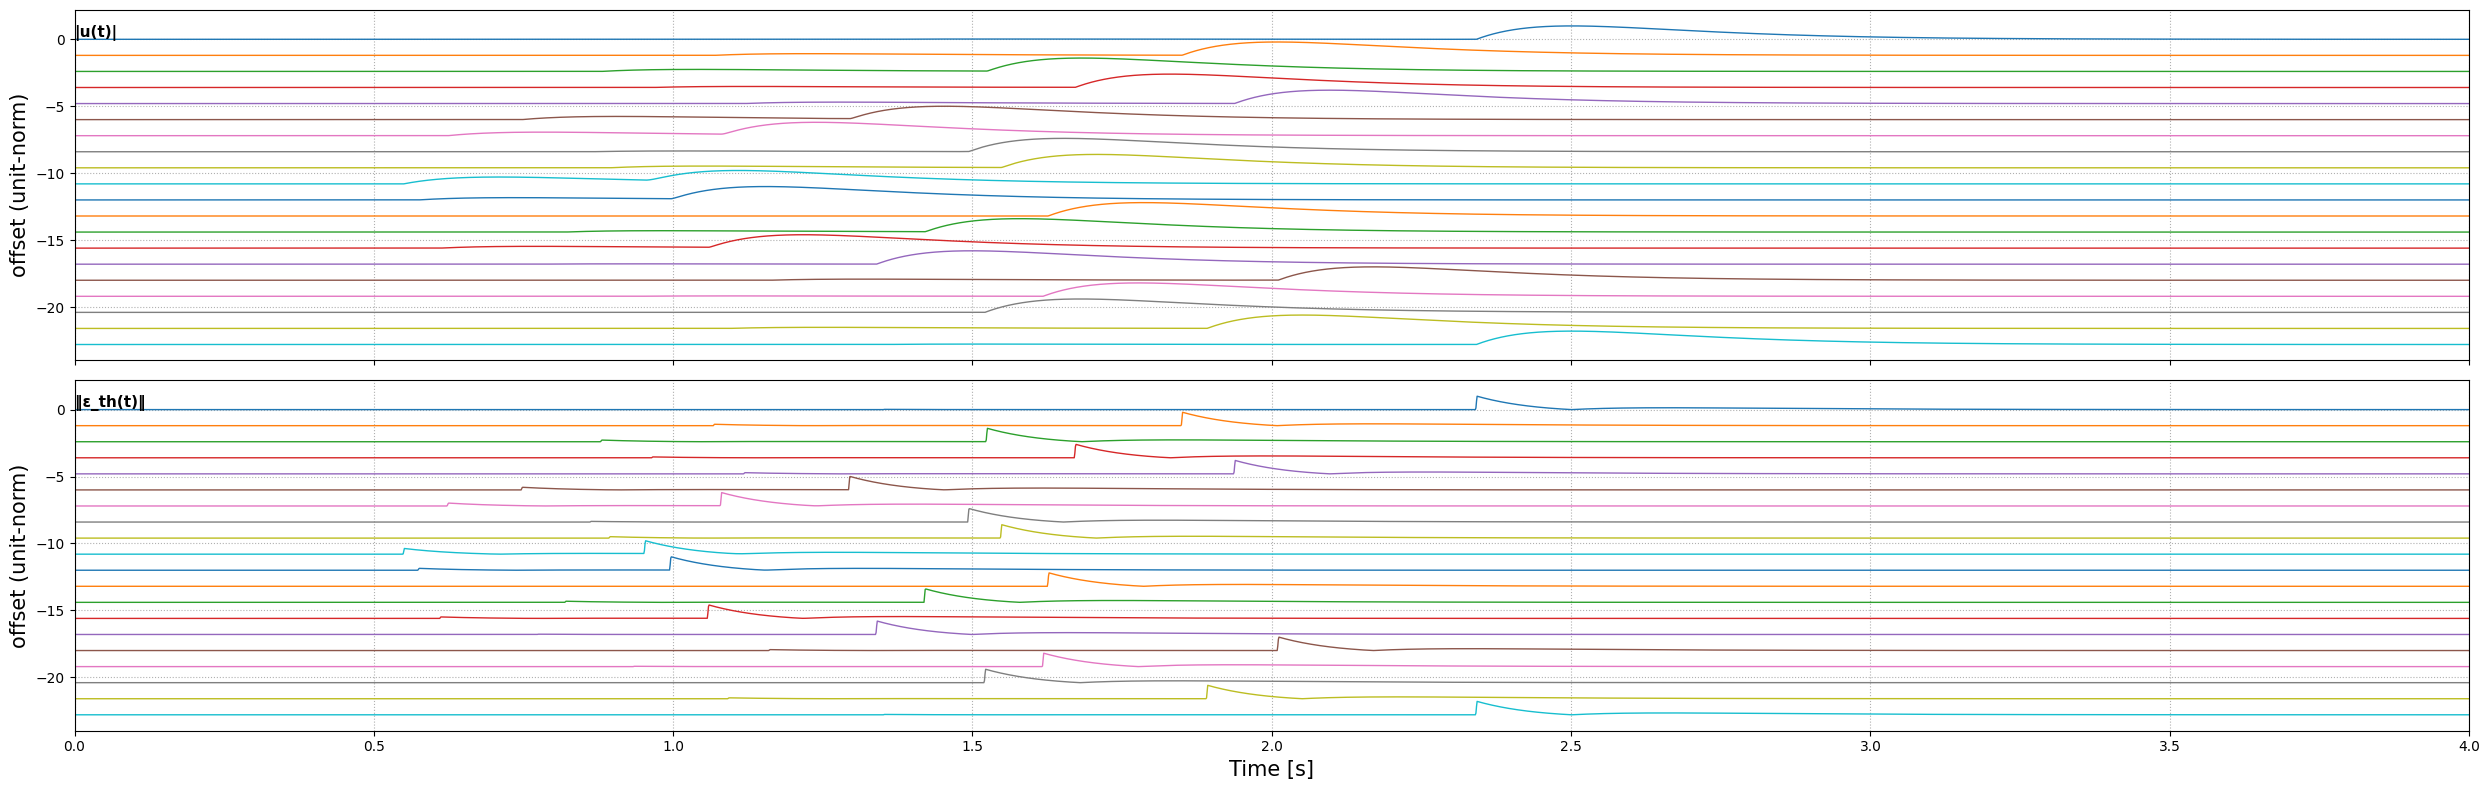

In [18]:
# === Part 3D: quick plot of u(t) and ε_th(t) for the CURRENT geometry (no recompute) ===

# time step
if 't' in globals():
    t_run = np.asarray(t, float)
    dt_run = float(t_run[1] - t_run[0])
else:
    t_run = np.arange(U_disp.shape[1], dtype=float) * float(dt)
    dt_run = float(dt)

# theoretical strain from the already-synthesized displacement
eps_th = strain_th_from_displacement(U_disp, stations_up, src_up, alpha, beta, dt=dt_run)

# build traces to show (normalize per-station; offset stack)
u_mag   = np.linalg.norm(U_disp, axis=2)                  # (nsta, nt)
eps_mag = np.sqrt(np.sum(eps_th**2, axis=(2,3)))          # (nsta, nt)

# optional: keep plots readable
max_show = 20
idx = np.linspace(0, u_mag.shape[0]-1, min(max_show, u_mag.shape[0])).astype(int)
u_mag, eps_mag = u_mag[idx], eps_mag[idx]

def offset_stack(ax, t, traces, label, stride=1.2):
    for i, tr in enumerate(traces):
        m = np.nanmax(np.abs(tr))
        y = tr/m if m > 0 else tr
        ax.plot(t, y - i*stride, lw=1.0)
    ax.set_ylabel("offset (unit-norm)", fontsize=15)
    ax.grid(True, ls=':')
    ax.set_xlim(0,4)
    ax.text(t[0], 0.2, label, fontsize=11, fontweight='bold')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 8), sharex=True)
offset_stack(ax1, t_run, u_mag,  "|u(t)|")
offset_stack(ax2, t_run, eps_mag, "‖ε_th(t)‖ ")
ax2.set_xlabel("Time [s]", fontsize=15)
plt.tight_layout()
plt.show()


In [19]:
# --- FD rotation from displacement/velocity on a surface array (no ∂/∂z) ---
# Matches your fd_strain conventions and grid handling.
def fd_rotation(U_disp, stations_up, U_vel=None):
    """
    Finite-difference rotation for a surface array (z-derivatives neglected).
    - U_disp: (nsta, nt, 3) displacement
    - stations_up: (nsta, 3) station coordinates (same frame as U)
    - U_vel: (nsta, nt, 3) velocity (optional). If given, also returns rotation-rate.

    Returns:
        rot_disp: (nsta, nt, 3) rotation (angle) vector θ
        rot_vel : (nsta, nt, 3) rotation-rate vector ω (or None if U_vel is None)
    """
    xs, ys, imap, dx, dy = _grid_indexer(stations_up)
    Ny, Nx = imap.shape
    nt = U_disp.shape[1]

    # grid the displacement (Ny, Nx, nt, 3)
    Ug = np.empty((Ny, Nx, nt, 3))
    for iy in range(Ny):
        for ix in range(Nx):
            Ug[iy, ix] = U_disp[imap[iy, ix]]

    # centered differences (same as your fd_strain)
    def cdiff_x(A, dx):
        out = np.full_like(A, np.nan)
        out[:, 1:-1] = (A[:, 2:] - A[:, :-2]) / (2 * dx)
        return out
    def cdiff_y(A, dy):
        out = np.full_like(A, np.nan)
        out[1:-1] = (A[2:] - A[:-2]) / (2 * dy)
        return out

    # spatial partials of components
    dux_dx = cdiff_x(Ug[..., 0], dx); dux_dy = cdiff_y(Ug[..., 0], dy)
    duy_dx = cdiff_x(Ug[..., 1], dx); duy_dy = cdiff_y(Ug[..., 1], dy)
    duz_dx = cdiff_x(Ug[..., 2], dx); duz_dy = cdiff_y(Ug[..., 2], dy)

    # Rotation (angle) vector θ = 0.5 * curl(u)
    # With ∂/∂z ≈ 0 → θx = 0.5*(∂uz/∂y), θy = -0.5*(∂uz/∂x), θz = 0.5*(∂uy/∂x - ∂ux/∂y)
    thetax = 0.5 * duz_dy
    thetay = -0.5 * duz_dx
    thetaz = 0.5 * (duy_dx - dux_dy)

    rotg = np.stack([thetax, thetay, thetaz], axis=-1)   # (Ny, Nx, nt, 3)

    # flatten back to station order
    rot_disp = np.empty((Nx * Ny, nt, 3))
    for iy in range(Ny):
        for ix in range(Nx):
            rot_disp[imap[iy, ix]] = rotg[iy, ix]

    # Optional: rotation-rate from velocity (ω = 0.5 * curl(u̇))
    rot_vel = None
    if U_vel is not None:
        Vg = np.empty((Ny, Nx, nt, 3))
        for iy in range(Ny):
            for ix in range(Nx):
                Vg[iy, ix] = U_vel[imap[iy, ix]]

        dvx_dx = cdiff_x(Vg[..., 0], dx); dvx_dy = cdiff_y(Vg[..., 0], dy)
        dvy_dx = cdiff_x(Vg[..., 1], dx); dvy_dy = cdiff_y(Vg[..., 1], dy)
        dvz_dx = cdiff_x(Vg[..., 2], dx); dvz_dy = cdiff_y(Vg[..., 2], dy)

        omegax = 0.5 * dvz_dy
        omegay = -0.5 * dvz_dx
        omegaz = 0.5 * (dvy_dx - dvx_dy)

        omegag = np.stack([omegax, omegay, omegaz], axis=-1)
        rot_vel = np.empty((Nx * Ny, nt, 3))
        for iy in range(Ny):
            for ix in range(Nx):
                rot_vel[imap[iy, ix]] = omegag[iy, ix]

    return rot_disp, rot_vel

# --- usage ---
rot_disp, rot_vel = fd_rotation(U_disp, stations_up, U_vel=U_vel)  # rot_vel=None if you omit U_vel


MSE curves

Using interior station sid= 280 coords= [5000.         -664.61538462   -0.        ] r= 4012.5023548814265


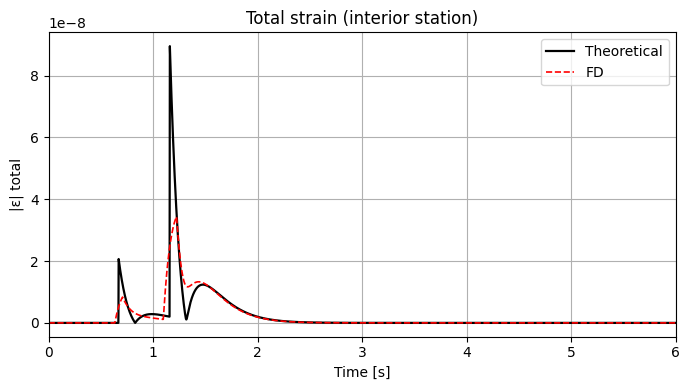

Strain NRMSE at interior station: 0.5481


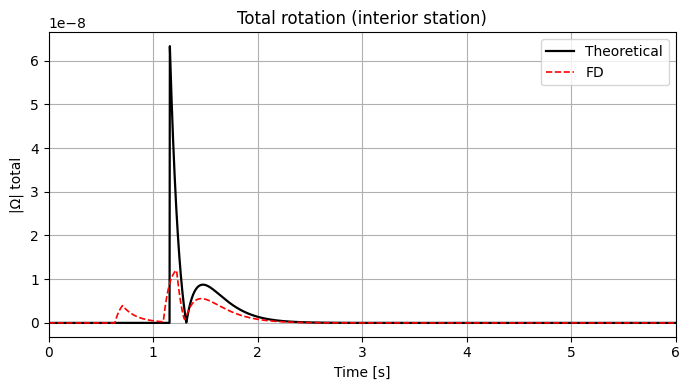

Rotation NRMSE at interior station: 0.7240


In [20]:
# choose a good interior station: r >= rmin, not on edges
f_peak = 1.3 * fc
lambda_S = beta / f_peak
rmin = 1.0 * lambda_S         # try 1–2 λS

xs, ys, imap, dx, dy = _grid_indexer(stations_up)
valid = (imap >= 0).ravel()
rvec = stations_up - src_up
r = np.linalg.norm(rvec, axis=1)

# interior mask (exclude boundary ring)
Ny, Nx = imap.shape
interior = np.zeros_like(imap, dtype=bool)
if Nx >= 3 and Ny >= 3:
    interior[1:-1, 1:-1] = True
interior_ids = imap[interior]
interior_ids = interior_ids[interior_ids >= 0]

# pick station closest to target radius among interior
target = 1.5 * lambda_S
cand = interior_ids[r[interior_ids] >= rmin]
sid = cand[np.argmin(np.abs(r[cand] - target))]
print("Using interior station sid=", sid, "coords=", stations_up[sid], "r=", r[sid])

# --- we computed: sid (interior), lambda_S, stations_up, src_up, U_disp, alpha, beta, fc ---


# ===== STRAIN (theoretical vs FD) =====
eps_th = strain_th_from_displacement(U_disp, stations_up, src_up, alpha, beta, dt=dt)
eps_fd = fd_strain(U_disp, stations_up)

def strain_norm(eps):  # eps: (nt,3,3)
    return np.sqrt(np.sum(eps**2, axis=(1,2)))

strain_th_total = strain_norm(eps_th[sid])
strain_fd_total = strain_norm(eps_fd[sid])

plt.figure(figsize=(7,4))
plt.plot(t, strain_th_total, 'k', lw=1.6, label='Theoretical')
plt.plot(t, strain_fd_total, 'r--', lw=1.2, label='FD')
plt.xlim(0,6)
plt.xlabel('Time [s]'); plt.ylabel('|ε| total'); plt.title('Total strain (interior station)')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

num = np.mean((strain_fd_total - strain_th_total)**2)
den = np.mean(strain_th_total**2)
print(f"Strain NRMSE at interior station: {np.sqrt(num/(den+1e-30)):.4f}")

# ===== ROTATION ANGLE θ (theoretical vs FD) =====
Omega_th = omega_th_from_displacement(U_disp, stations_up, src_up, beta, dt=dt)  # theoretical θ
rot_fd, _ = fd_rotation(U_disp, stations_up)                                     # FD θ from displacement

def rot_norm(omega):  # omega: (nt,3)
    return np.sqrt(np.sum(omega**2, axis=1))

rot_th_total = rot_norm(Omega_th[sid])
rot_fd_total = rot_norm(rot_fd[sid])

plt.figure(figsize=(7,4))
plt.plot(t, rot_th_total, 'k', lw=1.6, label='Theoretical')
plt.plot(t, rot_fd_total, 'r--', lw=1.2, label='FD')
plt.xlim(0,6)
plt.xlabel('Time [s]'); plt.ylabel('|Ω| total'); plt.title('Total rotation (interior station)')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

num = np.mean((rot_fd_total - rot_th_total)**2)
den = np.mean(rot_th_total**2)
print(f"Rotation NRMSE at interior station: {np.sqrt(num/(den+1e-30)):.4f}")


Δ/λS   N   nsta   achieved Δ/λS   NRMSE (interior, no εzz)   [A/λS fixed = 4]
0.125    33   1089         0.125               0.873
0.25    17    289         0.250               0.921
 0.5     9     81         0.500               0.979
 1.0     5     25         1.000               1.007
 2.0     3      9         2.000               1.001
 4.0     2      4         4.000                 nan


/var/folders/ny/76k9zwd14tz1r_gbckpd_5q80000gn/T/ipykernel_22072/3735309636.py:115: RuntimeWarning: Mean of empty slice
  num = np.nanmean(diff2);        den = np.nanmean(th2)


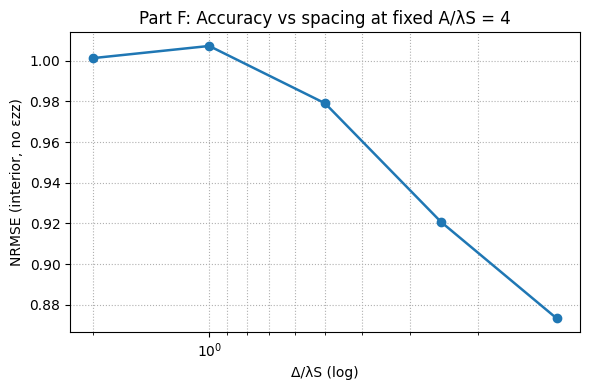

In [21]:
# ===== Part F: NRMSE vs Δ/λS at fixed A/λS = 4 (uses ONLY your existing vars/functions) =====
A_over_lamS = 4                        # fixed
Delta_curve = [0.125, 0.25, 0.5, 1.0, 2.0, 4.0]   # edit if you want
tmax_eval   = 20                                # crop time window for speed; set None to use full t
mask_preS   = False                                  # True → ignore pre‑S time in NRMSE

# ---- time grid from your notebook ----
if 't' in globals():
    t_all = np.asarray(t, float)
    dt_use = float(t_all[1] - t_all[0])
elif 'dt' in globals() and 'T' in globals():
    dt_use = float(dt)
    t_all  = np.arange(0.0, float(T), dt_use)
else:
    raise RuntimeError("Define 't' or both 'T' and 'dt' earlier.")

# optional crop
if (tmax_eval is not None) and (t_all[-1] > tmax_eval):
    mask_t = (t_all >= 0.0) & (t_all <= tmax_eval)
    t_use  = t_all[mask_t]
else:
    mask_t = slice(None)
    t_use  = t_all
dt_run = float(t_use[1] - t_use[0])

# ---- medium/source from your notebook ----
rho_use, alpha_use, beta_use = float(rho), float(alpha), float(beta)
fc_use = float(fc)

# ---- source (Z-up) ----
use_up = ('z_is_down' in globals()) and bool(z_is_down)
if 'src_up' in globals():
    src_up = np.asarray(src_up, float)
elif 'src' in globals():
    src_up = to_up(np.asarray(src, float)) if use_up else np.asarray(src, float)
else:
    # safely scalarize xs, ys, zs even if they are arrays
    src_up = (
        to_up(np.array([np.atleast_1d(xs)[0], np.atleast_1d(ys)[0], np.atleast_1d(zs)[0]], float))
        if use_up else
        np.array([np.atleast_1d(xs)[0], np.atleast_1d(ys)[0], np.atleast_1d(zs)[0]], float)
    )


# moment tensor to use
if 'M_hat' in globals():
    M_used = np.array(M_hat, float)
elif 'mech' in globals() and isinstance(mech, dict) and len(mech):
    M_used = np.array(list(mech.values())[0], float)
else:
    raise RuntimeError("Need M_hat (or a 'mech' dict) defined earlier.")

# ---- wavelength and constants ----
f_peak   = 1.3 * fc_use
lambda_S = beta_use / f_peak

I3 = np.eye(3)

# center arrays on source XY so arrivals stay in-window
center_xy = (src_up[0], src_up[1])

# source pulse on the (possibly cropped) time grid
mdot_run  = brune_mdot(t_use, M0=1.0, fc=fc_use, shape="gamma2")

rows = []  # each: [Δ/λS, N, nsta, achieved Δ/λS, NRMSE]

for Delta_lS in Delta_curve:
    # --- array for this Δ/λS (aperture fixed) ---
    stations, meta = make_surface_array_from_lambdaS(Delta_lS, A_over_lamS, lambda_S, center_xy=center_xy)
    stations_up = to_up(stations) if use_up else stations

    # --- synthesize U_disp on t_use (far-field P+S with ṁ) ---
    nsta, nt = stations_up.shape[0], t_use.size
    U_disp = np.zeros((nsta, nt, 3), float)
    for i in range(nsta):
        rvec = stations_up[i] - src_up
        rmag = np.linalg.norm(rvec)
        if rmag <= 0: 
            continue
        n = rvec / rmag
        Sproj  = I3 - np.outer(n, n)
        Mn_hat = M_used @ n
        A_P_hat = float(n @ Mn_hat)     # scalar
        A_S_hat = Sproj @ Mn_hat        # 3-vector

        tP, tS = rmag/alpha_use, rmag/beta_use
        mdP = np.interp(t_use - tP, t_use, mdot_run, left=0.0, right=0.0)
        mdS = np.interp(t_use - tS, t_use, mdot_run, left=0.0, right=0.0)

        U_disp[i] += (cP*A_P_hat/rmag) * mdP[:,None] * n[None,:]
        U_disp[i] += (cS/rmag)         * mdS[:,None] * A_S_hat[None,:]

    # --- theoretical & FD strain on this grid ---
    eps_th = strain_th_from_displacement(U_disp, stations_up, src_up, alpha_use, beta_use, dt=dt_run)
    eps_fd = fd_strain(U_disp, stations_up)

    # --- interior-average NRMSE (εzz excluded) ---
    xs_g, ys_g, imap, dx, dy = _grid_indexer(stations_up)
    Ny, Nx = imap.shape
    ids = (imap[1:-1,1:-1].ravel() if (Nx>=3 and Ny>=3) else imap.ravel())
    ids = ids[ids >= 0]

    Eth = eps_th[ids].copy(); Efd = eps_fd[ids].copy()
    Eth[...,2,2] = 0.0;        Efd[...,2,2] = 0.0
    diff2 = np.sum((Efd - Eth)**2, axis=(2,3))  # (ns, nt)
    th2   = np.sum(Eth**2,         axis=(2,3))

    if mask_preS:
        # simple mask: ignore times earlier than the minimum S arrival of the interior
        r = np.linalg.norm(stations_up[ids] - src_up, axis=1)
        tS_min = np.min(r)/beta_use
        mt = t_use >= tS_min
        num = np.nanmean(diff2[:, mt]); den = np.nanmean(th2[:, mt])
    else:
        num = np.nanmean(diff2);        den = np.nanmean(th2)

    NRMSE = np.nan if den == 0 else np.sqrt(num)/(np.sqrt(den)+1e-30)
    rows.append([Delta_lS, meta["N"], meta["nsta"], meta["delta"]/lambda_S, float(NRMSE)])

# ---- print table ----
print("Δ/λS   N   nsta   achieved Δ/λS   NRMSE (interior, no εzz)   [A/λS fixed = 4]")
for Delta_lS, N, nsta, d_ach, nrmse in rows:
    print(f"{Delta_lS:>4}   {N:3d}  {nsta:5d}        {d_ach:6.3f}              {nrmse:6.3f}")

# ---- plot curve ----
Dvals = [r[0] for r in rows]
NR    = [r[4] for r in rows]

plt.figure(figsize=(6,4))
plt.plot(Dvals, NR, 'o-', lw=1.8)
plt.xscale('log'); plt.gca().invert_xaxis()
plt.grid(True, which='both', ls=':')
plt.xlabel("Δ/λS (log)")
plt.ylabel("NRMSE (interior, no εzz)")
plt.title(f"Part F: Accuracy vs spacing at fixed A/λS = {A_over_lamS}")
plt.tight_layout(); plt.show()


Rotation angle θ NRMSE vs Δ/λS  (A/λS fixed = 4)
Δ/λS   N   nsta   achieved Δ/λS   NRMSE(θ)
0.125   33   1089         0.125         0.6761
 0.25   17    289         0.250         0.7814
  0.5    9     81         0.500         0.8842
  1.0    5     25         1.000         0.9597
  2.0    3      9         2.000         0.9983
  4.0    2      4         4.000            nan


/var/folders/ny/76k9zwd14tz1r_gbckpd_5q80000gn/T/ipykernel_22072/3126993752.py:83: RuntimeWarning: Mean of empty slice
  num = np.nanmean((theta_fd - theta_th)**2)


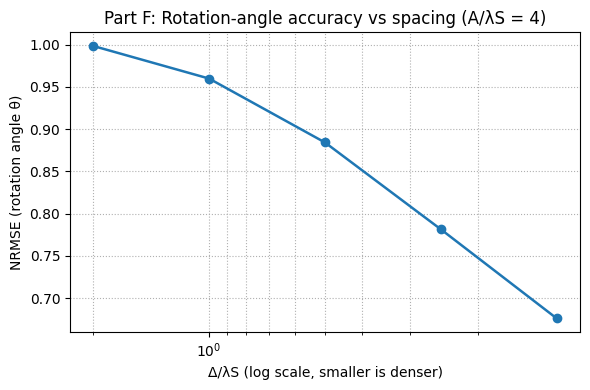

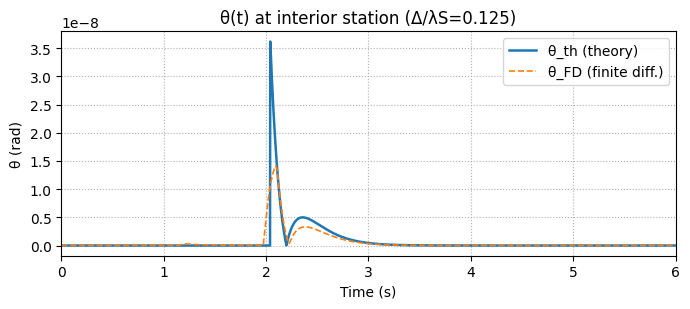

In [22]:
# ===== Part F (Rotation angle θ): NRMSE vs Δ/λS at fixed A/λS, using your existing functions =====
# time window
t_all = np.asarray(t, float)
if (tmax_eval is not None) and (t_all[-1] > tmax_eval):
    m_t = (t_all >= 0.0) & (t_all <= tmax_eval)
    t_use = t_all[m_t]
else:
    m_t = slice(None)
    t_use = t_all

# geometry wavelength from your current fc
f_peak   = 1.3 * fc
lambda_S = beta / f_peak

# source & center (Z-up if needed)
src_up = to_up(np.array([np.atleast_1d(xs)[0], np.atleast_1d(ys)[0], np.atleast_1d(zs)[0]], float)) if use_up else np.array([np.atleast_1d(xs)[0], np.atleast_1d(ys)[0], np.atleast_1d(zs)[0]], float)


# source pulse on t_use
mdot_run = brune_mdot(t_use, M0=1.0, fc=fc)

rows = []    # [Δ/λS, N, nsta, achieved Δ/λS, NRMSE(θ)]
curves = []  # for optional per-Δ plotting later

for Delta_lS in Delta_curve:
    # --- array for this Δ/λS with fixed A/λS ---
    stations, meta = make_surface_array_from_lambdaS(Delta_lS, A_over_lamS, lambda_S, center_xy=(src_up[0], src_up[1]))
    stations_up = to_up(stations) if ('z_is_down' in globals() and z_is_down) else stations
    nsta, nt = stations_up.shape[0], t_use.size

    # --- synthesize U_disp on this grid/time using your far-field formula (reusing globals) ---
    U_disp = np.zeros((nsta, nt, 3), float)
    cP = 1.0 / (4.0*np.pi*rho*alpha**3)   # tiny intermediates (not redefining your globals)
    cS = 1.0 / (4.0*np.pi*rho*beta**3)
    I3 = np.eye(3)

    for i in range(nsta):
        rvec = stations_up[i] - src_up
        rmag = np.linalg.norm(rvec)
        if rmag <= 0: 
            continue
        n = rvec / rmag
        Sproj  = I3 - np.outer(n, n)
        Mn_hat = M_hat @ n
        A_P = float(n @ Mn_hat)      # scalar
        A_S = Sproj @ Mn_hat         # 3-vector

        tP, tS = rmag/alpha, rmag/beta
        mdP = np.interp(t_use - tP, t_use, mdot_run, left=0.0, right=0.0)
        mdS = np.interp(t_use - tS, t_use, mdot_run, left=0.0, right=0.0)

        U_disp[i] += (cP*A_P/rmag) * mdP[:,None] * n[None,:]
        U_disp[i] += (cS/rmag)     * mdS[:,None] * A_S[None,:]

    # --- theoretical rotation (your function expects U_disp, not U_vel) ---
    Omega_th = omega_th_from_displacement(U_disp, stations_up, src_up, beta, dt=dt)

    # --- FD rotation (your function) ---
    rot_fd, _ = fd_rotation(U_disp, stations_up)   # returns (nsta, nt, 3)

    # --- compare using total rotation angle θ(t) = ||omega(t)|| ---
    # choose interior stations only (avoid edges for FD)
    xs_g, ys_g, imap, dx, dy = _grid_indexer(stations_up)
    Ny, Nx = imap.shape
    ids = (imap[1:-1,1:-1].ravel() if (Nx>=3 and Ny>=3) else imap.ravel())
    ids = ids[ids >= 0]

    # optional: mask out pre-S times
    if mask_preS:
        r_all = np.linalg.norm(stations_up[ids] - src_up, axis=1)
        tS_min = np.min(r_all)/beta
        m_eval = (t_use >= tS_min)
    else:
        m_eval = slice(None)

    # form θ_th, θ_fd and aggregate NRMSE across interior stations
    def _theta_total(omega):   # omega: (nsta, nt, 3)
        return np.sqrt(np.sum(omega**2, axis=2))   # (nsta, nt)

    theta_th = _theta_total(Omega_th)[ids][:, m_eval]  # (ns, nt_sel)
    theta_fd = _theta_total(rot_fd)[ids][:, m_eval]

    num = np.nanmean((theta_fd - theta_th)**2)
    den = np.nanmean(theta_th**2)
    nrmse = np.nan if den == 0 else np.sqrt(num)/(np.sqrt(den)+1e-30)

    rows.append([Delta_lS, meta["N"], meta["nsta"], meta["delta"]/lambda_S, float(nrmse)])
    curves.append((Delta_lS, theta_th, theta_fd, t_use[m_eval]))

# ---- print table ----
print(f"Rotation angle θ NRMSE vs Δ/λS  (A/λS fixed = {A_over_lamS})")
print("Δ/λS   N   nsta   achieved Δ/λS   NRMSE(θ)")
for Delta_lS, N, nsta, d_ach, nrmse in rows:
    print(f"{Delta_lS:>5}  {N:3d}  {nsta:5d}        {d_ach:6.3f}       {nrmse:8.4f}")

# ---- plot curve ----
Dvals = [r[0] for r in rows]
NR    = [r[4] for r in rows]
plt.figure(figsize=(6,4))
plt.plot(Dvals, NR, 'o-', lw=1.8)
plt.xscale('log'); plt.gca().invert_xaxis()
plt.grid(True, which='both', ls=':')
plt.xlabel("Δ/λS (log scale, smaller is denser)")
plt.ylabel("NRMSE (rotation angle θ)")
plt.title(f"Part F: Rotation-angle accuracy vs spacing (A/λS = {A_over_lamS})")
plt.tight_layout(); plt.show()

# ---- optional: visualize one interior station's θ(t) at the finest Δ/λS for sanity ----
if len(curves):
    Delta_lS, th, fd, t_eval = curves[0]   # pick first entry (smallest Δ/λS in your list)
    # choose the most central station among the interior ids
    xs_g, ys_g, imap, dx, dy = _grid_indexer(stations_up)  # latest grid in scope
    Ny, Nx = imap.shape
    cx, cy = Nx//2, Ny//2
    sid = int(imap[cy, cx]) if imap[cy, cx] >= 0 else int(ids[len(ids)//2])
    # plot that station (find its index within interior subset)
    ii = np.where(ids == sid)[0][0] if sid in ids else 0
    plt.figure(figsize=(7,3.2))
    plt.plot(t_eval, th[ii],  lw=1.8, label='θ_th (theory)')
    plt.plot(t_eval, fd[ii],  lw=1.2, ls='--', label='θ_FD (finite diff.)')
    plt.grid(True, ls=':'); plt.xlim(t_eval[0], t_eval[-1])
    plt.xlim(0,6)
    plt.xlabel('Time (s)'); plt.ylabel('θ (rad)')
    plt.title(f"θ(t) at interior station (Δ/λS={Delta_lS})")
    plt.legend(); plt.tight_layout(); plt.show()


[Comparable] Rotation NRMSE @ central station, Δ/λS=0.125: 0.9349
[Comparable] Rotation NRMSE @ central station, Δ/λS=0.25: 0.9420
[Comparable] Rotation NRMSE @ central station, Δ/λS=0.5: 0.9563
[Comparable] Rotation NRMSE @ central station, Δ/λS=1.0: 0.9858
[Comparable] Rotation NRMSE @ central station, Δ/λS=2.0: 0.9983
[Comparable] Rotation NRMSE @ central station, Δ/λS=4.0: nan

Rotation θ NRMSE vs Δ/λS — interior average (Cell 23‑style)
Δ/λS   N   nsta   achieved Δ/λS   NRMSE_avg(θ)
0.125   33   1089         0.125         0.6761
0.25   17    289         0.250         0.7814
 0.5    9     81         0.500         0.8842
 1.0    5     25         1.000         0.9597
 2.0    3      9         2.000         0.9983
 4.0    2      4         4.000            nan

Rotation θ NRMSE vs Δ/λS — central station (Cell 23‑style)
Δ/λS   NRMSE_station(θ)
0.125     0.9349
0.25     0.9420
 0.5     0.9563
 1.0     0.9858
 2.0     0.9983
 4.0        nan


/var/folders/ny/76k9zwd14tz1r_gbckpd_5q80000gn/T/ipykernel_22072/1967330147.py:96: RuntimeWarning: Mean of empty slice
  num = np.nanmean((theta_fd[ids][:, m_eval] - theta_th[ids][:, m_eval])**2)
/var/folders/ny/76k9zwd14tz1r_gbckpd_5q80000gn/T/ipykernel_22072/1967330147.py:102: RuntimeWarning: Mean of empty slice
  num_s = np.nanmean((theta_fd[ii, m_eval] - theta_th[ii, m_eval])**2)


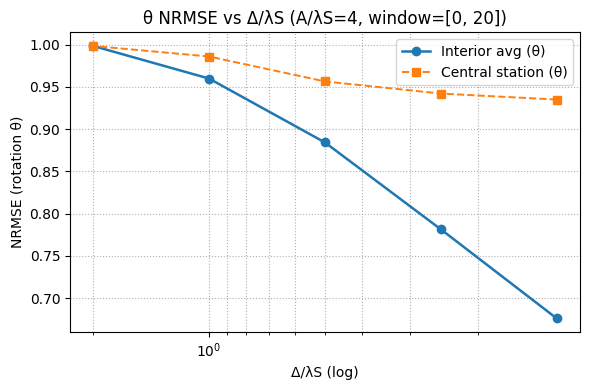

In [23]:
# ===== Part F (ROTATION θ): NRMSE vs Δ/λS — comparable for a single station value or and average =====
t_window = [0,20]
t_all = np.asarray(t, float)
t_use = t_all.copy()
dt_run = float(t_use[1] - t_use[0])

rho_use, alpha_use, beta_use = float(rho), float(alpha), float(beta)
fc_use = float(fc)
f_peak = 1.3 * fc_use
lambda_S = beta_use / f_peak

use_up = ('z_is_down' in globals()) and bool(z_is_down)
if 'src_up' in globals():
    src_up = np.asarray(src_up, float)
elif 'src' in globals():
    src_up = to_up(np.asarray(src, float)) if use_up else np.asarray(src, float)
else:
    src_up = (
        to_up(np.array([np.atleast_1d(xs)[0], np.atleast_1d(ys)[0], np.atleast_1d(zs)[0]], float))
        if use_up else
        np.array([np.atleast_1d(xs)[0], np.atleast_1d(ys)[0], np.atleast_1d(zs)[0]], float)
    )

if 'M_hat' in globals():
    M_used = np.array(M_hat, float)
elif 'mech' in globals() and isinstance(mech, dict) and len(mech):
    M_used = np.array(list(mech.values())[0], float)
else:
    raise RuntimeError("Need M_hat (or a 'mech' dict).")

mdot_run = brune_mdot(t_use, M0=1.0, fc=fc_use, shape="gamma2")
cP = 1.0 / (4.0*np.pi*rho_use*alpha_use**3)
cS = 1.0 / (4.0*np.pi*rho_use*beta_use**3)
I3 = np.eye(3)

def _grid_interior_ids(stations):
    xs_g, ys_g, imap, dx, dy = _grid_indexer(stations)
    Ny, Nx = imap.shape
    ids = (imap[1:-1,1:-1].ravel() if (Nx >= 3 and Ny >= 3) else imap.ravel())
    return ids[ids >= 0], imap

def _theta_total(omega):  # omega: (nsta, nt, 3)
    return np.sqrt(np.sum(omega**2, axis=2))  # (nsta, nt)

def _time_mask(tvals, t_window):
    if t_window is None: return slice(None)
    lo, hi = float(t_window[0]), float(t_window[1])
    return (tvals >= lo) & (tvals <= hi)

rows_avg, rows_station = [], []

for Delta_lS in Delta_curve:
    stations, meta = make_surface_array_from_lambdaS(
        Delta_lS, A_over_lamS, lambda_S, center_xy=(src_up[0], src_up[1])
    )
    stations_up = to_up(stations) if use_up else stations
    nsta, nt = stations_up.shape[0], t_use.size

    # synthesize U
    U_disp = np.zeros((nsta, nt, 3), float)
    for i in range(nsta):
        rvec = stations_up[i] - src_up
        rmag = np.linalg.norm(rvec)
        if rmag <= 0: continue
        n = rvec / rmag
        Sproj  = I3 - np.outer(n, n)
        Mn_hat = M_used @ n
        A_P = float(n @ Mn_hat)
        A_S = Sproj @ Mn_hat
        tP, tS = rmag/alpha_use, rmag/beta_use
        mdP = np.interp(t_use - tP, t_use, mdot_run, left=0.0, right=0.0)
        mdS = np.interp(t_use - tS, t_use, mdot_run, left=0.0, right=0.0)
        U_disp[i] += (cP*A_P/rmag) * mdP[:,None] * n[None,:]
        U_disp[i] += (cS/rmag)     * mdS[:,None] * A_S[None,:]

    # theoretical & FD rotation
    Omega_th = omega_th_from_displacement(U_disp, stations_up, src_up, beta_use, dt=dt_run)  # (nsta, nt, 3)
    rot_fd, _ = fd_rotation(U_disp, stations_up)                                            # (nsta, nt, 3)

    ids, imap = _grid_interior_ids(stations_up)
    if ids.size == 0:
        rows_avg.append([Delta_lS, meta["N"], meta["nsta"], meta["delta"]/lambda_S, np.nan])
        rows_station.append([Delta_lS, np.nan])
        print(f"[Δ/λS={Delta_lS}] (no interior stations) → NRMSE=nan")
        continue
    Ny, Nx = imap.shape
    cx, cy = Nx//2, Ny//2
    ii = int(imap[cy, cx]) if imap[cy, cx] >= 0 else int(ids[len(ids)//2])

    m_eval = _time_mask(t_use, t_window)

    theta_th = _theta_total(Omega_th)
    theta_fd = _theta_total(rot_fd)

    # interior‑average θ‑NRMSE
    num = np.nanmean((theta_fd[ids][:, m_eval] - theta_th[ids][:, m_eval])**2)
    den = np.nanmean(theta_th[ids][:, m_eval]**2)
    nrmse_avg = np.nan if den == 0 else np.sqrt(num) / (np.sqrt(den) + 1e-30)
    rows_avg.append([Delta_lS, meta["N"], meta["nsta"], meta["delta"]/lambda_S, float(nrmse_avg)])

    # central station θ‑NRMSE
    num_s = np.nanmean((theta_fd[ii, m_eval] - theta_th[ii, m_eval])**2)
    den_s = np.nanmean(theta_th[ii, m_eval]**2)
    nrmse_station = np.nan if den_s == 0 else np.sqrt(num_s) / (np.sqrt(den_s) + 1e-30)
    rows_station.append([Delta_lS, float(nrmse_station)])
    print(f"[Comparable] Rotation NRMSE @ central station, Δ/λS={Delta_lS}: {nrmse_station:.4f}")

# print + plot
print("\nRotation θ NRMSE vs Δ/λS — interior average (Cell 23‑style)")
print("Δ/λS   N   nsta   achieved Δ/λS   NRMSE_avg(θ)")
for Delta_lS, N, nsta, d_ach, nrmse in rows_avg:
    print(f"{Delta_lS:>4}  {N:3d}  {nsta:5d}        {d_ach:6.3f}       {nrmse:8.4f}")

print("\nRotation θ NRMSE vs Δ/λS — central station (Cell 23‑style)")
print("Δ/λS   NRMSE_station(θ)")
for Delta_lS, nrmse_s in rows_station:
    print(f"{Delta_lS:>4}   {nrmse_s:8.4f}")

Dvals = np.array([r[0] for r in rows_avg], float)
NRavg = np.array([r[4] for r in rows_avg], float)
NR1   = np.array([r[1] for r in rows_station], float)

plt.figure(figsize=(6,4))
plt.plot(Dvals, NRavg, 'o-', lw=1.8, label='Interior avg (θ)')
plt.plot(Dvals, NR1,   's--', lw=1.4, label='Central station (θ)')
plt.xscale('log'); plt.gca().invert_xaxis()
plt.grid(True, which='both', ls=':')
plt.xlabel("Δ/λS (log)")
plt.ylabel("NRMSE (rotation θ)")
plt.title(f"θ NRMSE vs Δ/λS (A/λS={A_over_lamS}, window={t_window})")
plt.legend()
plt.tight_layout(); plt.show()


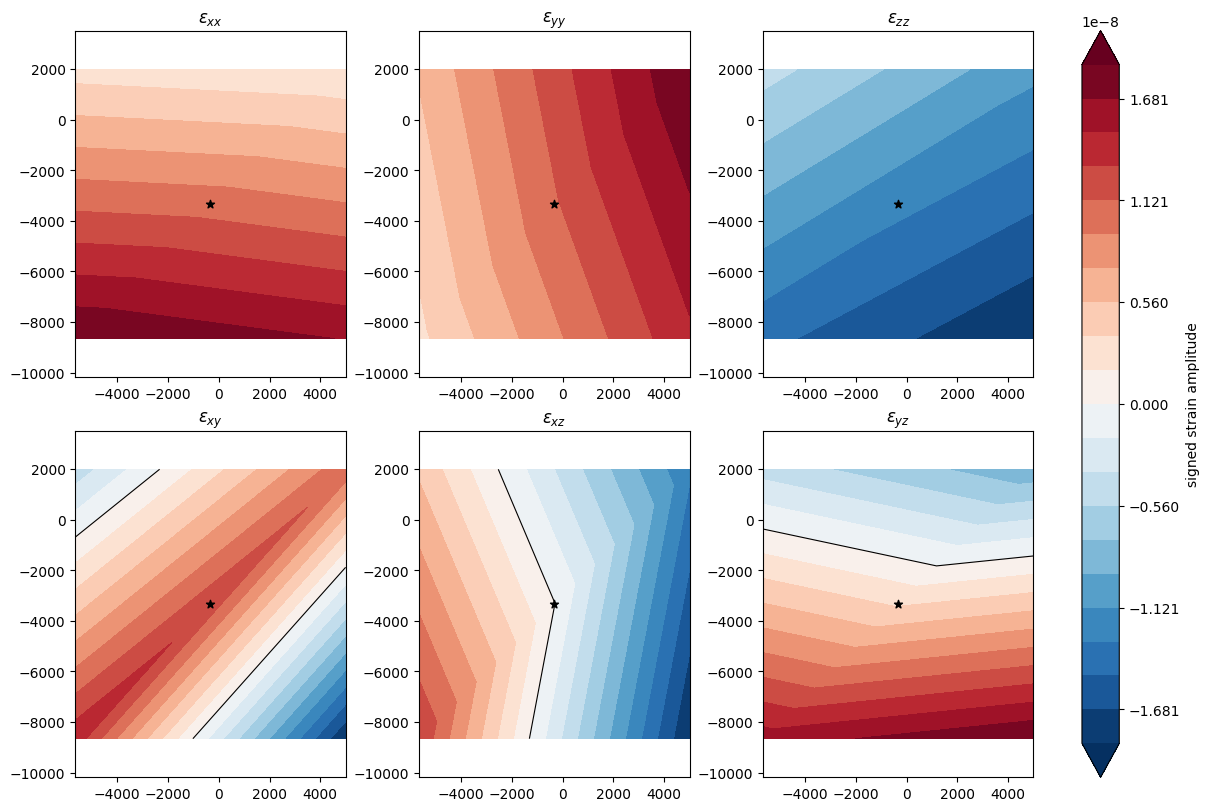

In [24]:
# ===== Part F: Visualize strain fields (theoretical) at maximum amplitude time =====
comps = [(0,0), (1,1), (2,2), (0,1), (0,2), (1,2)]
labels = [r'$\varepsilon_{xx}$', r'$\varepsilon_{yy}$', r'$\varepsilon_{zz}$',
          r'$\varepsilon_{xy}$', r'$\varepsilon_{xz}$', r'$\varepsilon_{yz}$']
import numpy as np, matplotlib.tri as mtri, matplotlib.pyplot as plt
fig, axs = plt.subplots(2,3, figsize=(12,8), constrained_layout=True)
for ax, comp, label in zip(axs.flat, comps, labels):
    F = eps_th[:, :, comp[0], comp[1]]
    imax = np.argmax(np.abs(F), axis=1)
    Z = F[np.arange(F.shape[0]), imax]
    xs = stations_up[ids,0]; ys = stations_up[ids,1]; Z = Z[ids]
    tri = mtri.Triangulation(xs, ys)
    v = np.nanmax(np.abs(Z))
    cs = ax.tricontourf(tri, Z, levels=np.linspace(-v,v,21), cmap='RdBu_r', extend='both')
    # correct for triangulated data
    ax.tricontour(tri, Z, levels=[0], colors='k', linewidths=0.8)

    ax.scatter(src_up[0], src_up[1], color='k', marker='*')
    ax.set_title(label); ax.axis('equal')
fig.colorbar(cs, ax=axs.ravel().tolist(), label='signed strain amplitude')
plt.show()


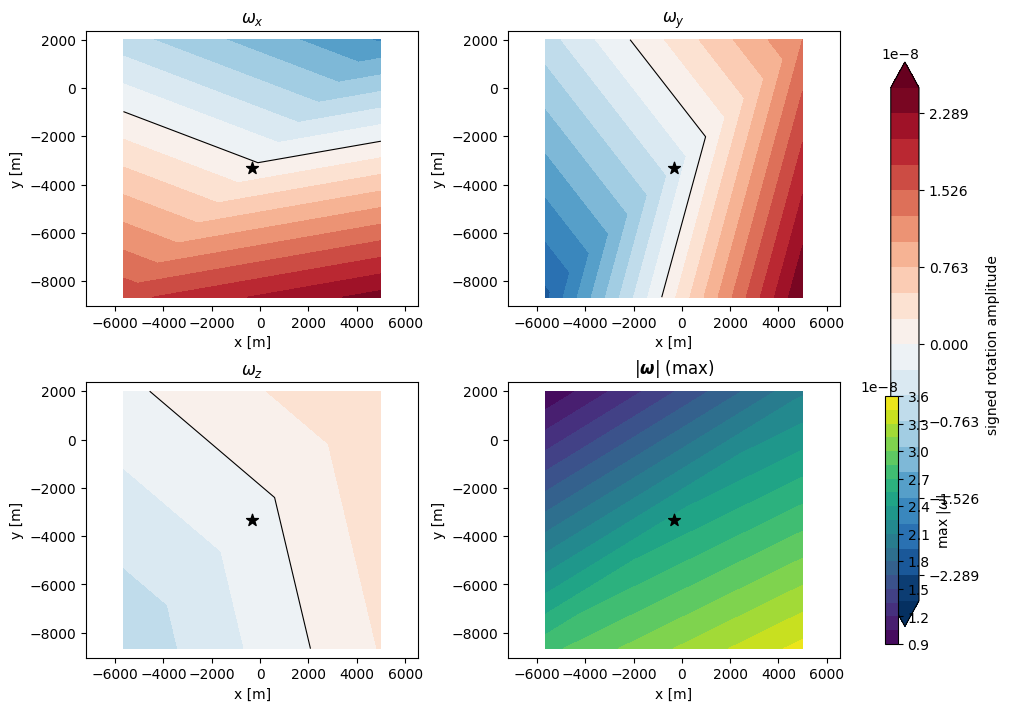

In [25]:
# --- Rotation radiation patterns
ROT = Omega_th   # or: rot_fd
# interior ids already defined as in your strain code:
# ids = (imap[1:-1,1:-1].ravel() if (Nx>=3 and Ny>=3) else imap.ravel()); ids = ids[ids>=0]
xs = stations_up[ids,0]; ys = stations_up[ids,1]

def signed_peak(A):                    # A: (nsta, nt)
    imax = np.argmax(np.abs(A), axis=1)
    return A[np.arange(A.shape[0]), imax]

Zx = signed_peak(ROT[:,:,0])[ids]
Zy = signed_peak(ROT[:,:,1])[ids]
Zz = signed_peak(ROT[:,:,2])[ids]
Zmag = np.max(np.sqrt((ROT**2).sum(axis=2)), axis=1)[ids]   # max |ω|

tri = mtri.Triangulation(xs, ys)
v = np.nanmax(np.abs(np.concatenate([Zx, Zy, Zz])))         # same range for ωx,ωy,ωz
levels = np.linspace(-v, v, 21)

fig, axs = plt.subplots(2, 2, figsize=(10,7), constrained_layout=True)

for ax, Z, lab in zip(axs.flat[:3], [Zx, Zy, Zz], [r'$\omega_x$', r'$\omega_y$', r'$\omega_z$']):
    cs = ax.tricontourf(tri, Z, levels=levels, cmap='RdBu_r', extend='both')
    ax.tricontour(tri, Z, levels=[0], colors='k', linewidths=0.8)      # nodal line
    ax.scatter(src_up[0], src_up[1], marker='*', s=80, color='k')
    ax.set_title(lab); ax.axis('equal'); ax.set_xlabel('x [m]'); ax.set_ylabel('y [m]')

im = axs[1,1].tricontourf(tri, Zmag, levels=21, cmap='viridis')        # |ω| panel
axs[1,1].scatter(src_up[0], src_up[1], marker='*', s=80, color='k')
axs[1,1].set_title(r'$|\boldsymbol{\omega}|$ (max)'); axs[1,1].axis('equal'); axs[1,1].set_xlabel('x [m]'); axs[1,1].set_ylabel('y [m]')

fig.colorbar(cs, ax=[axs[0,0], axs[0,1], axs[1,0]], shrink=0.9, label='signed rotation amplitude')
fig.colorbar(im, ax=[axs[1,1]], shrink=0.9, label=r'max $|\omega|$')
plt.show()
